In [97]:
# encoding 
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

df = pd.read_csv('nyc_subway_ml_data.csv')

# label encoding - station
le_enc = LabelEncoder()
df['station_enc'] = le_enc.fit_transform(df['station'])

#save map
station_map = dict(zip(le_enc.transform(le_enc.classes_), le_enc.classes_))

# one hot encoding - borough
df = pd.get_dummies(df, columns = ['borough'], prefix = 'boro')
df= df.drop(['station', 'transaction_time'], axis = 1)

# scale the entry_per_hour - only for random forest 
scaler_rf = MinMaxScaler()
cols_to_scale = ['entry_per_hour', 'hr_lag', 'day_lag', 'week_lag']
df_rf = df.copy()
df_rf[cols_to_scale] = scaler_rf.fit_transform(df_rf[cols_to_scale])
df_rf = df_rf.astype(float)

print(df_rf.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429600 entries, 0 to 429599
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   entry_per_hour  429600 non-null  float64
 1   hour            429600 non-null  float64
 2   weekday         429600 non-null  float64
 3   month           429600 non-null  float64
 4   is_weekend      429600 non-null  float64
 5   is_rush_hr      429600 non-null  float64
 6   is_holiday      429600 non-null  float64
 7   hr_lag          429600 non-null  float64
 8   day_lag         429600 non-null  float64
 9   week_lag        429600 non-null  float64
 10  station_enc     429600 non-null  float64
 11  boro_Bronx      429600 non-null  float64
 12  boro_Brooklyn   429600 non-null  float64
 13  boro_Manhattan  429600 non-null  float64
 14  boro_Queens     429600 non-null  float64
dtypes: float64(15)
memory usage: 49.2 MB
None


,entry_per_hour,hour,weekday,month,is_weekend,is_rush_hr,is_holiday,hr_lag,day_lag,week_lag,station_enc,boro_Bronx,boro_Brooklyn,boro_Manhattan,boro_Queens
0,447.0,0,6,1,1,0,0,706.0,501.0,469.0,0,False,False,True,False
1,66.0,0,6,1,1,0,0,123.0,71.0,139.0,1,False,False,False,True
2,122.0,0,6,1,1,0,0,227.0,119.0,210.0,2,False,False,True,False
3,726.0,0,6,1,1,0,0,1033.0,773.0,961.0,3,False,False,True,False
4,618.0,0,6,1,1,0,0,914.0,640.0,688.0,4,False,False,True,False


In [33]:
# 1. Random Forest Regressor 
# Jan - Oct: training Nov, Dec: testing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

divide_month = 10
training_data = df_rf[df_rf['month'] <= divide_month]
X_train_rf = training_data.drop(columns = 'entry_per_hour')
y_train_rf = training_data['entry_per_hour']

testing_data = df_rf[df_rf['month'] > divide_month]
X_test_rf = testing_data.drop('entry_per_hour', axis = 1)
y_test_rf = testing_data['entry_per_hour']

rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 67)
rf.fit(X_train_rf, y_train_rf)
pred = rf.predict(X_test_rf)

mse = mean_squared_error(y_test_rf, pred)
rmse = np.sqrt(mse) 
mae = mean_absolute_error(y_test_rf, pred)
r2 = r2_score(y_test_rf, pred)

print(f'R2 Score (Accuracy): {r2:.4f}') 
print(f'RMSE: {rmse:.4f}')
print(f'MAE:  {mae:.4f}')

R2 Score (Accuracy): 0.9651
RMSE: 0.0146
MAE:  0.0062


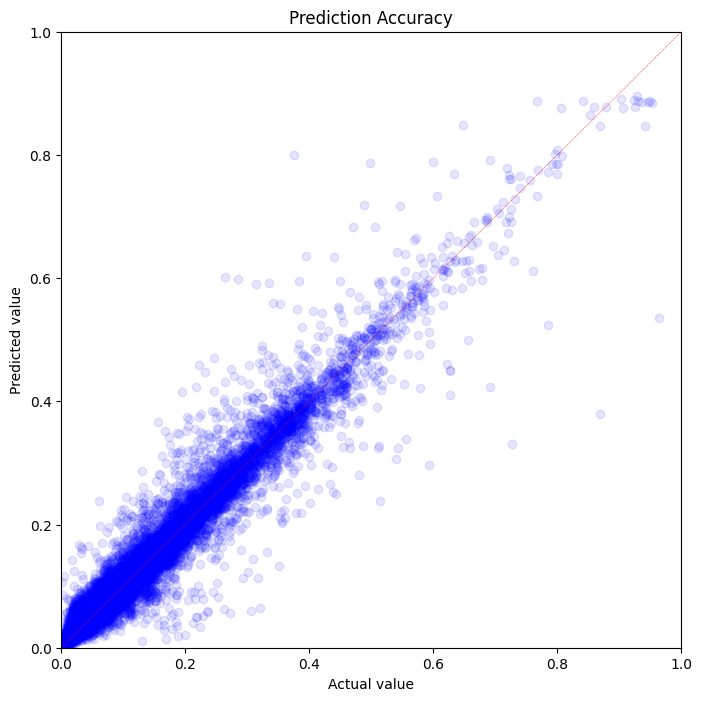

In [34]:
# some visualization of the regressor model 
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize = (8, 8))
plt.scatter(y_test_rf, pred, alpha = 0.1, color = 'blue')
plt.plot([0, 1], [0, 1], color = 'red', linestyle = '--', linewidth = 0.3)

plt.title("Prediction Accuracy")
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

/var/folders/8q/3bk4mhcd2l38k0_tbmtbbsv80000gn/T/ipykernel_24793/2945728153.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')


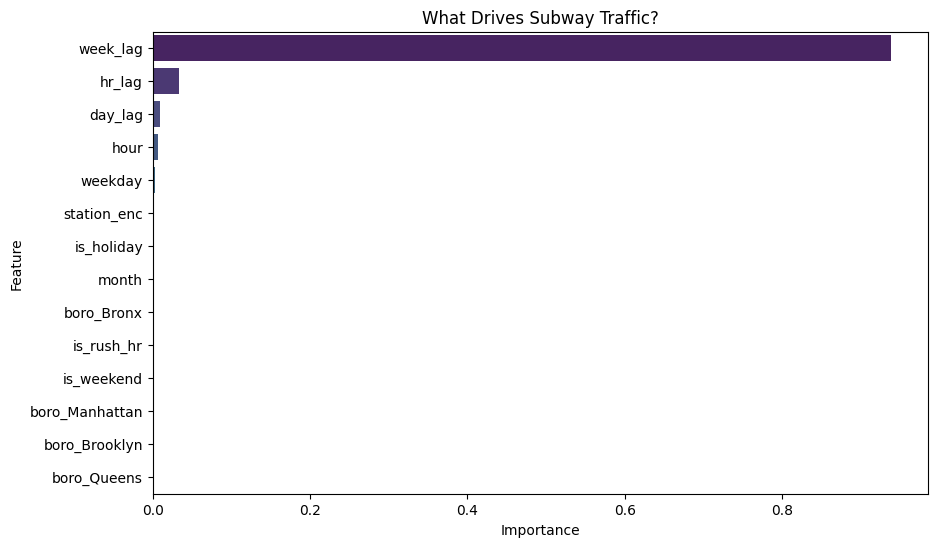

In [35]:
importances = rf.feature_importances_
feature_names = X_train_rf.columns

fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('What Drives Subway Traffic?')
plt.show()

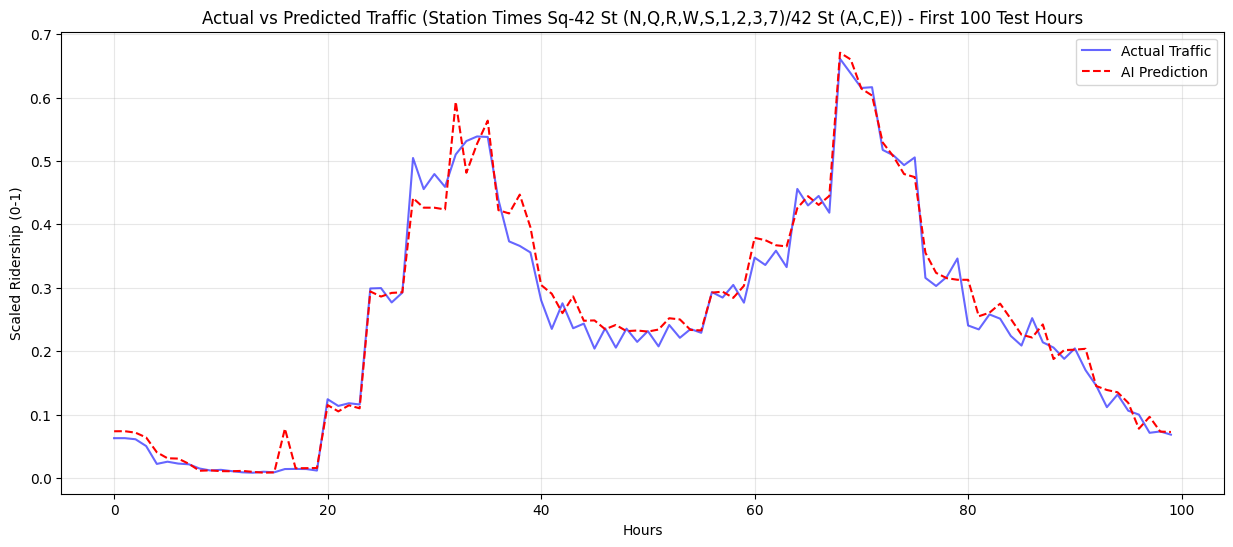

In [36]:
results_df = X_test_rf.copy()
results_df['Actual'] = y_test_rf
results_df['Predicted'] = pred

target_station = 48
subset = results_df[results_df['station_enc'] == target_station]

subset = subset.sort_values(by=['month', 'weekday', 'hour'])
plt.figure(figsize=(15, 6))
plt.plot(subset['Actual'].values[:100], label='Actual Traffic', color='blue', alpha=0.6)
plt.plot(subset['Predicted'].values[:100], label='AI Prediction', color='red', linestyle='--')

plt.title(f"Actual vs Predicted Traffic (Station {station_map[target_station]}) - First 100 Test Hours")
plt.xlabel("Hours")
plt.ylabel("Scaled Ridership (0-1)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [93]:
df_nn = df.copy()

month_cutoff = 10
training_data = df_nn[df_nn['month'] <= month_cutoff]
X_train_nn = training_data.drop('entry_per_hour', axis = 1)
y_train_nn = training_data['entry_per_hour']

testing_data = df_nn[df_nn['month'] > month_cutoff]
X_test_nn = testing_data.drop('entry_per_hour', axis = 1)
y_test_nn = testing_data['entry_per_hour']

X_train_nn = X_train_nn.astype('float32')
y_train_nn = y_train_nn.astype('float32')
X_test_nn = X_test_nn.astype('float32')
y_test_nn = y_test_nn.astype('float32')

print("Shape of y_train:", y_train_nn.shape)
print("Max ridership:", y_train_nn.max())
print("Average ridership:", y_train_nn.mean())
print("Sample of values:", y_train_nn.head(10).tolist())

Shape of y_train: (356400,)
Max ridership: 20168.0
Average ridership: 1180.2698
Sample of values: [447.0, 66.0, 122.0, 726.0, 618.0, 1148.0, 56.0, 138.0, 224.0, 183.0]


In [94]:
# Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

scaler_nn = StandardScaler()
X_train_scaled_nn = scaler_nn.fit_transform(X_train_nn)
X_test_scaled_nn = scaler_nn.transform(X_test_nn)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, verbose = 1)

model = Sequential()

# Input Layer
model = Sequential()

model.add(Dense(256, input_dim = X_train_nn.shape[1], activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'relu'))

model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit(X_train_scaled_nn, y_train_nn, epochs = 100, batch_size = 64, 
                    validation_data = (X_test_scaled_nn, y_test_nn), callbacks = [early_stopping, lr_scheduler], verbose = 1)

Epoch 1/100


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5569/5569 ━━━━━━━━━━━━━━━━━━━━ 5s 751us/step - loss: 206.2741 - val_loss: 157.7201 - learning_rate: 0.0010
Epoch 2/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 5s 834us/step - loss: 172.7930 - val_loss: 151.0164 - learning_rate: 0.0010
Epoch 3/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 5s 809us/step - loss: 166.9316 - val_loss: 147.2169 - learning_rate: 0.0010
Epoch 4/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 5s 845us/step - loss: 162.2910 - val_loss: 146.4899 - learning_rate: 0.0010
Epoch 5/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 756us/step - loss: 159.7515 - val_loss: 145.2413 - learning_rate: 0.0010
Epoch 6/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 765us/step - loss: 157.8449 - val_loss: 143.7165 - learning_rate: 0.0010
Epoch 7/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 731us/step - loss: 155.9304 - val_loss: 141.9984 - learning_rate: 0.0010
Epoch 8/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 767us/step - loss: 153.0449 - val_loss: 136.1614 - learning_rate: 0.0010
Epoch 9/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 770us/step - l

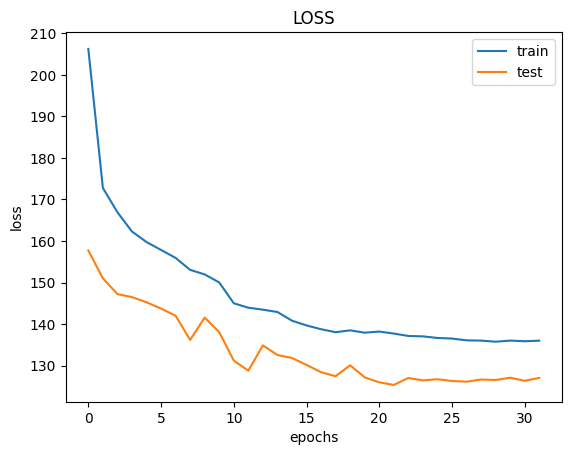

In [95]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [111]:
# 3. LSTM model
# stick with time_step = 1 / the lag columns already takes account of historical data 
df_lstm = df.copy()
month_cutoff = 10

training_data = df_lstm[df_lstm['month'] <= month_cutoff]

training_data = df_lstm[df_lstm['month'] <= month_cutoff]
X_train_lstm = training_data.drop('entry_per_hour', axis = 1)
y_train_lstm = training_data['entry_per_hour']

testing_data = df_lstm[df_lstm['month'] > month_cutoff]
X_test_lstm = testing_data.drop('entry_per_hour', axis = 1)
y_test_lstm = testing_data['entry_per_hour']

X_train_lstm = X_train_lstm.astype('float32')
y_train_lstm = y_train_lstm.astype('float32')
X_test_lstm = X_test_lstm.astype('float32')
y_test_lstm = y_test_lstm.astype('float32')

scaler_lstm = StandardScaler()
X_train_lstm_scaled = scaler_lstm.fit_transform(X_train_lstm)
X_test_lstm_scaled = scaler_lstm.transform(X_test_lstm)

X_train_lstm = X_train_lstm_scaled.reshape((X_train_lstm_scaled.shape[0], 1, X_train_lstm_scaled.shape[1]))
X_test_lstm = X_test_lstm_scaled.reshape((X_test_lstm_scaled.shape[0], 1, X_test_lstm_scaled.shape[1]))

print(f"Original Shape: {X_train_lstm_scaled.shape}")
print(f"new shape: {X_train_lstm.shape}")

Original Shape: (356400, 14)
new shape: (356400, 1, 14)


In [ ]:
from tensorflow.keras.layers import LSTM

model2 = Sequential()

model2.add(LSTM(128, return_sequences = True, input_shape = (1, X_train_lstm.shape[2])))
model2.add(Dropout(0.3))

model2.add(LSTM(64, return_sequences = False))
model2.add(Dropout(0.3))

model2.add(Dense(32, activation = 'relu'))
model2.add(Dense(1, activation = 'relu'))

model2.compile(loss = 'mean_absolute_error', optimizer = 'adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history2 = model2.fit(
    X_train_lstm, y_train_lstm,
    epochs=50, 
    batch_size=64,
    validation_data=(X_test_lstm, y_test_lstm),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)           

Epoch 1/50


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5569/5569 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 178.3090 - val_loss: 154.9692 - learning_rate: 0.0010
Epoch 2/50
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 127.0451 - val_loss: 158.8506 - learning_rate: 0.0010
Epoch 3/50
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 120.6343 - val_loss: 138.3142 - learning_rate: 0.0010
Epoch 4/50
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 117.0134 - val_loss: 135.2527 - learning_rate: 0.0010
Epoch 5/50
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 114.5069 - val_loss: 130.8189 - learning_rate: 0.0010
Epoch 6/50
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 112.3444 - val_loss: 135.0283 - learning_rate: 0.0010
Epoch 7/50
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 110.3526 - val_loss: 130.2244 - learning_rate: 0.0010
Epoch 8/50
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 107.9963 - val_loss: 130.3877 - learning_rate: 0.0010
Epoch 9/50
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 106.1377 - v

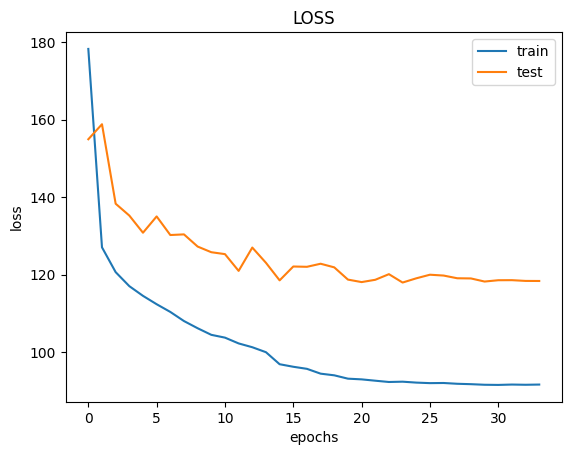

In [114]:
plt.plot(history2.history['loss'], label = 'train')
plt.plot(history2.history['val_loss'], label = 'test')
plt.legend()
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [115]:
pred_nn_raw = model.predict(X_test_scaled_nn) 
pred_lstm_raw = model2.predict(X_test_lstm)
pred_rf_scaled = rf.predict(X_test_rf) 

dummy_matrix = np.zeros((len(pred_rf_scaled), 4))
dummy_matrix[:, 0] = pred_rf_scaled
inverse_matrix = scaler_rf.inverse_transform(dummy_matrix) 
pred_rf_real = inverse_matrix[:, 0]

scores = {
    'Model': ['Random Forest', 'Neural Network (Dense)', 'LSTM (Time)'],
    'MAE (Avg Error in Riders)': [
        mean_absolute_error(y_test_nn, pred_rf_real), 
        mean_absolute_error(y_test_nn, pred_nn_raw),
        mean_absolute_error(y_test_lstm, pred_lstm_raw)
    ],
    'R2 Score (Accuracy)': [
        r2_score(y_test_nn, pred_rf_real),
        r2_score(y_test_nn, pred_nn_raw),
        r2_score(y_test_lstm, pred_lstm_raw)
    ]
}

comparison_df = pd.DataFrame(scores)
print(comparison_df)

2288/2288 ━━━━━━━━━━━━━━━━━━━━ 1s 242us/step
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 1s 559us/step
                    Model  MAE (Avg Error in Riders)  R2 Score (Accuracy)
0           Random Forest                 124.808165             0.965051
1  Neural Network (Dense)                 125.331337             0.966005
2             LSTM (Time)                 117.945244             0.971624


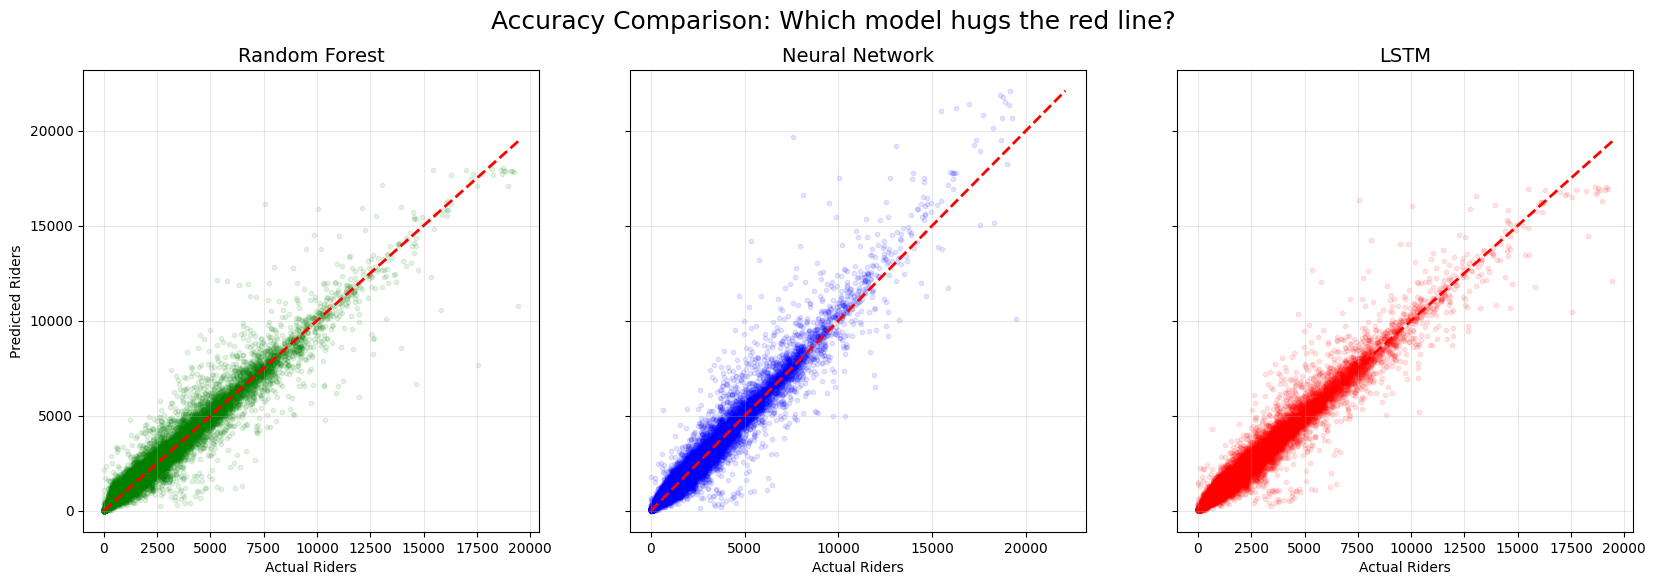

In [69]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Helper function to plot
def plot_scatter(ax, y_true, y_pred, title, color):
    ax.scatter(y_true, y_pred, alpha=0.1, color=color, s=10)
    # Diagonal Perfect Line
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([0, max_val], [0, max_val], 'r--', lw=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Actual Riders')
    ax.grid(True, alpha=0.3)

# 1. Random Forest
plot_scatter(axes[0], y_test_nn, pred_rf_real, 'Random Forest', 'green')
axes[0].set_ylabel('Predicted Riders')

# 2. Neural Network
plot_scatter(axes[1], y_test_nn, pred_nn_raw, 'Neural Network', 'blue')

# 3. LSTM
plot_scatter(axes[2], y_test_lstm, pred_lstm_raw, 'LSTM', 'red')

plt.suptitle('Accuracy Comparison: Which model hugs the red line?', fontsize=18)
plt.show()

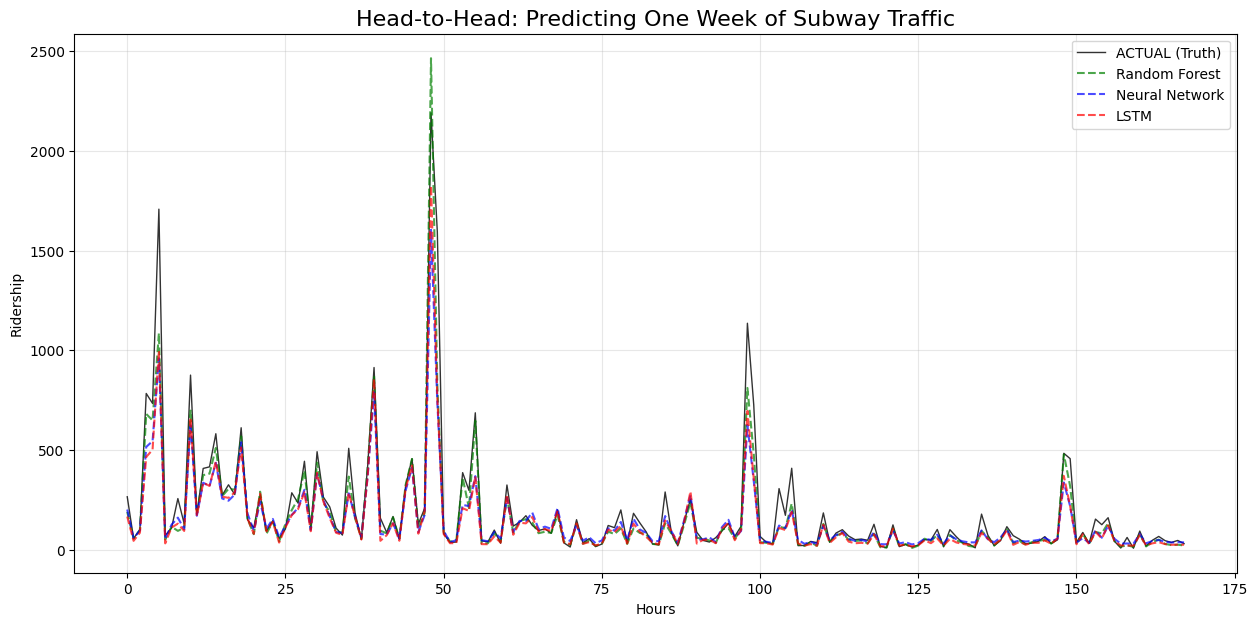

In [71]:
import matplotlib.pyplot as plt

# Ensure all predictions are flat arrays (1D)
y_true = y_test_nn.values.flatten()
p_rf = pred_rf_real.flatten()
p_nn = pred_nn_raw.flatten()
p_lstm = pred_lstm_raw.flatten()

# Set the window (e.g., First 1 week = 168 hours)
start = 0
end = 168 

plt.figure(figsize=(15, 7))

# Plot Truth
plt.plot(y_true[start:end], label='ACTUAL (Truth)', color='black', linewidth=1, alpha=0.8)

# Plot Models (using dashed lines to see overlaps)
plt.plot(p_rf[start:end], label='Random Forest', color='green', linestyle='--', alpha=0.7)
plt.plot(p_nn[start:end], label='Neural Network', color='blue', linestyle='--', alpha=0.7)
plt.plot(p_lstm[start:end], label='LSTM', color='red', linestyle='--', alpha=0.7)

plt.title('Head-to-Head: Predicting One Week of Subway Traffic', fontsize=16)
plt.ylabel('Ridership')
plt.xlabel('Hours')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()